
回帰の設定

特徴量が量的変数，アヤメの種類が3クラスの質的変数である

→アヤメの特徴量からアヤメの種類を予測する多項ロジスティック回帰モデルを作成する

https://www.kaggle.com/datasets/uciml/iris

In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
sns.set(style='darkgrid')

In [ ]:
iris = pd.read_csv(input_dir+'iris-data.csv')
display(iris)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


説明変数がアヤメの特徴量，目的変数がアヤメの種類である

$\mu=\alpha+\beta X$ \\
$\theta=\operatorname{softmax}(\mu)$ \\
$y \sim \operatorname{Cat}(\theta)$

の多項ロジスティック回帰モデルを作る

In [ ]:
y_s = pd.Categorical(iris['target']).codes
x_s = iris.iloc[:, [0,1,2,3]].values
x_s =(x_s - x_s.mean(axis=0)/x_s.std(axis=0)) #データの標準化

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha +pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)
    
    likelihood = pm.Categorical('y', p=theta, observed=y_s)

In [ ]:
with model:
    step = pm.NUTS()
    trace = pm.sample(draws=5000, chains=4, tune=1000, random_seed=123)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 386 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f187aeb59d0>,
      dtype=object)

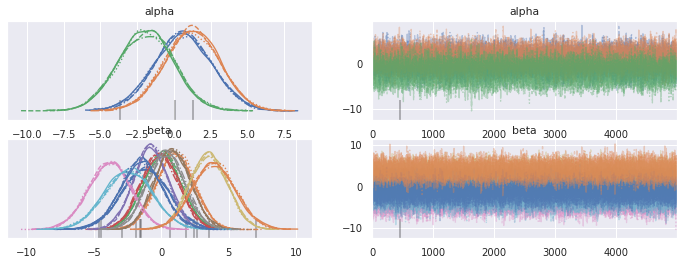

In [ ]:
pm.traceplot(trace)

In [ ]:
print(trace['alpha'].mean(axis = 0))

[ 0.64437978  1.22850533 -1.89280097]


In [ ]:
print(trace['beta'].mean(axis = 0))

[[-1.18428521  1.05959561  0.09348497]
 [-0.09893002 -0.77274188  0.84664365]
 [-3.84778513  0.35008198  3.5052466 ]
 [-2.4406302  -1.47875275  3.90762396]]


サンプリングで得られたパラメーターの平均を用いた回帰モデルに対してアヤメの特徴量を入力値とした予測値を生成

In [ ]:
data_pred =trace['alpha'].mean(axis=0)+np.dot(x_s,trace["beta"].mean(axis=0))
y_pred=[]
for point in data_pred:
  y_pred.append(np.exp(point)/np.sum(np.exp(point),axis=0))
np.sum(y_s==np.argmax(y_pred,axis=1))/len(y_s)

0.96